     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
✅ Step 1: Libraries installed and imported.

🔄 Step 2: Loading dataset components...
   - Loading metadata from annotations.csv...


README.md:   0%|          | 0.00/959 [00:00<?, ?B/s]

annotations.csv:   0%|          | 0.00/159M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

   - Metadata loaded successfully.
   - Downloading images.zip from Hugging Face Hub...


images.zip:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

   - Image archive downloaded to: /root/.cache/huggingface/hub/datasets--balgot--stylegan3-annotated/snapshots/3bcedcafc087390b96754917951b07f31fcde589/images.zip
   - Unzipping images to 'stylegan3_images' directory...


   - Extracting :   0%|          | 0/20001 [00:00<?, ?it/s]

✅ Step 2: Dataset components are ready.

🔄 Step 3: Loading CLIP model...


100%|███████████████████████████████████████| 890M/890M [01:16<00:00, 12.2MiB/s]


   - Loaded CLIP ViT-L/14 on cuda.
   - Target emotion: sad
   - Quality threshold: 0.6
   - Emotion threshold: 0.55
✅ Step 3: CLIP model loaded with quality filters.

🔄 Step 4: Processing images to find sad faces with quality control...


   - Classifying:   0%|          | 0/20000 [00:00<?, ?it/s]

✅ Step 4: Image processing complete.
   - 3047 images filtered out due to poor quality
   - 12105 images filtered out due to insufficient sad confidence

📊 Step 5: Results for sad faces

Processed 20000 images.
Found 4848 high-quality sad faces.

Top 10 sad faces with highest confidence:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,seed,emotion_confidence,quality_score,emotion_type
3797,15448,0.997559,0.774414,sad
671,2825,0.997070,0.647949,sad
3790,15416,0.997070,0.944336,sad
2225,9029,0.996582,0.874023,sad
1369,5667,0.996094,0.875000,sad
4438,18213,0.996094,0.944336,sad
4723,19461,0.995605,0.941895,sad
206,907,0.995117,0.850098,sad
483,2037,0.995117,0.699219,sad
180,790,0.995117,0.665527,sad



🖼️ Sample of detected sad faces:
--- Seed: 15448, Sad Confidence: 0.9976, Quality: 0.7744 ---


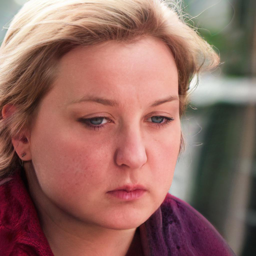

--- Seed: 2825, Sad Confidence: 0.9971, Quality: 0.6479 ---


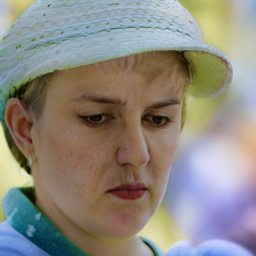

--- Seed: 15416, Sad Confidence: 0.9971, Quality: 0.9443 ---


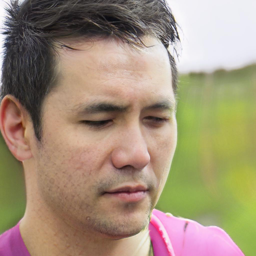

--- Seed: 9029, Sad Confidence: 0.9966, Quality: 0.8740 ---


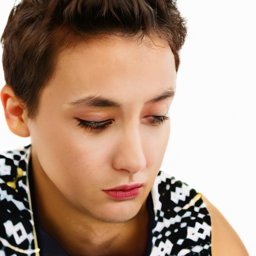

--- Seed: 5667, Sad Confidence: 0.9961, Quality: 0.8750 ---


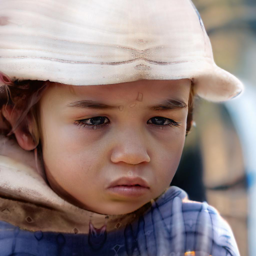

--- Seed: 18213, Sad Confidence: 0.9961, Quality: 0.9443 ---


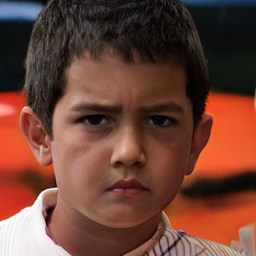

--- Seed: 19461, Sad Confidence: 0.9956, Quality: 0.9419 ---


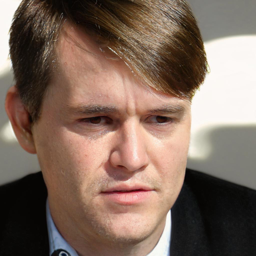

--- Seed: 907, Sad Confidence: 0.9951, Quality: 0.8501 ---


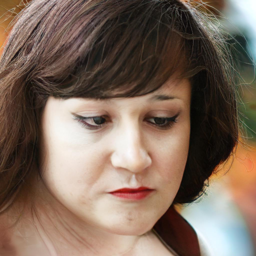


💾 Step 6: Saving sad faces...
   - Metadata saved to sad_faces_output/sad_faces_metadata.csv
   - Uncomment the shutil section to also save image files

   - Saving 4848 individual latent vectors to: sad_faces_output/sad_vectors


KeyError: 'latent_vector'

In [1]:
#@title Isolate Sad/Less Smiling Faces with Quality Filter
# Step 1: Install and import necessary libraries
!pip install -q datasets ftfy regex tqdm openai-clip Pillow huggingface_hub
!pip install --upgrade -q Pillow

import os
import zipfile
from tqdm.auto import tqdm
import torch
import clip
from PIL import Image
import numpy as np
import pandas as pd
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from IPython.display import display

print("✅ Step 1: Libraries installed and imported.")

# Step 2: Load metadata and manually download & extract images
print("\n🔄 Step 2: Loading dataset components...")

try:
    # Part A: Load ONLY the metadata from the CSV file.
    print("   - Loading metadata from annotations.csv...")
    metadata_dataset = load_dataset("balgot/stylegan3-annotated", data_files="annotations.csv", split='train')
    print("   - Metadata loaded successfully.")

    # Part B: Manually download the images.zip file.
    print("   - Downloading images.zip from Hugging Face Hub...")
    zip_path = hf_hub_download(
        repo_id="balgot/stylegan3-annotated",
        filename="images.zip",
        repo_type="dataset"
    )
    print(f"   - Image archive downloaded to: {zip_path}")

    # Part C: Extract the zip file to a known directory.
    extract_path = "stylegan3_images"
    os.makedirs(extract_path, exist_ok=True)
    print(f"   - Unzipping images to '{extract_path}' directory...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc="   - Extracting "):
            zip_ref.extract(member, extract_path)

except Exception as e:
    print(f"   - FATAL ERROR during data loading/extraction: {e}")
    exit()

print("✅ Step 2: Dataset components are ready.")

# Step 3: Load the CLIP model
print("\n🔄 Step 3: Loading CLIP model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    model, preprocess = clip.load("ViT-L/14", device=device)
    print(f"   - Loaded CLIP ViT-L/14 on {device}.")
except Exception:
    print("   - Could not load ViT-L/14, falling back to ViT-B/32.")
    model, preprocess = clip.load("ViT-B/32", device=device)
    print(f"   - Loaded CLIP ViT-B/32 on {device}.")

# Define emotion categories and quality filters
emotion_prompts = {
    "sad": ["a photo of a happy face", "a photo of a sad face"],
    "melancholy": ["a photo of a cheerful face", "a photo of a melancholy face"],
    "depressed": ["a photo of a joyful face", "a photo of a depressed face"],
    "less_smiling": ["a photo of a face with a big smile", "a photo of a face with no smile"],
    "serious": ["a photo of a laughing face", "a photo of a serious face"]
}

# Quality control prompts to filter out flawed faces
quality_prompts = [
    "a high quality photo of a realistic human face",
    "a blurry, distorted, or malformed face"
]

# Choose your target emotion here
TARGET_EMOTION = "sad"  # Change this to: "sad", "melancholy", "depressed", "less_smiling", or "serious"
QUALITY_THRESHOLD = 0.6  # Minimum quality score (0-1) to include the image
EMOTION_THRESHOLD = 0.55  # Minimum confidence for target emotion

print(f"   - Target emotion: {TARGET_EMOTION}")
print(f"   - Quality threshold: {QUALITY_THRESHOLD}")
print(f"   - Emotion threshold: {EMOTION_THRESHOLD}")

# Tokenize prompts
emotion_text_prompts = emotion_prompts[TARGET_EMOTION]
emotion_tokens = clip.tokenize(emotion_text_prompts).to(device)
quality_tokens = clip.tokenize(quality_prompts).to(device)

print("✅ Step 3: CLIP model loaded with quality filters.")

# Step 4: Process images and filter for target emotion with quality control
print(f"\n🔄 Step 4: Processing images to find {TARGET_EMOTION} faces with quality control...")

target_faces_data = []
quality_filtered_count = 0
emotion_filtered_count = 0

with torch.no_grad():
    # Iterate through the metadata
    for item in tqdm(metadata_dataset, desc="   - Classifying"):
        try:
            filename = f"{str(item['seed']).zfill(5)}.jpg"
            image_path = os.path.join(extract_path, "data", "stylegan_images", filename)

            # Open the image and preprocess it
            pil_image = Image.open(image_path)
            image_tensor = preprocess(pil_image).unsqueeze(0).to(device)

            # Step 4a: Quality check
            quality_logits, _ = model(image_tensor, quality_tokens)
            quality_probs = quality_logits.softmax(dim=-1).cpu().numpy()
            quality_score = quality_probs[0][0]  # Probability of "high quality realistic face"

            if quality_score < QUALITY_THRESHOLD:
                quality_filtered_count += 1
                continue  # Skip this image due to poor quality

            # Step 4b: Emotion classification
            emotion_logits, _ = model(image_tensor, emotion_tokens)
            emotion_probs = emotion_logits.softmax(dim=-1).cpu().numpy()

            # For target emotion (index 1 in our prompts)
            emotion_prediction = np.argmax(emotion_probs)
            emotion_confidence = np.max(emotion_probs)
            target_emotion_score = emotion_probs[0][1]  # Probability of target emotion

            # If the model predicted the target emotion with sufficient confidence
            if emotion_prediction == 1 and target_emotion_score >= EMOTION_THRESHOLD:
                target_faces_data.append({
                    'full_path': image_path,
                    'seed': item['seed'],
                    'emotion_confidence': target_emotion_score,
                    'quality_score': quality_score,
                    'original_caption': item['text'],
                    'emotion_type': TARGET_EMOTION
                })
            else:
                emotion_filtered_count += 1

        except FileNotFoundError:
            print(f"   - CRITICAL: Image file not found at {image_path}. Skipping.")
        except Exception as e:
            print(f"   - Warning: Could not process {image_path}. Error: {e}. Skipping.")

print(f"✅ Step 4: Image processing complete.")
print(f"   - {quality_filtered_count} images filtered out due to poor quality")
print(f"   - {emotion_filtered_count} images filtered out due to insufficient {TARGET_EMOTION} confidence")

# Step 5: Display the results
print(f"\n📊 Step 5: Results for {TARGET_EMOTION} faces")

df_target_emotion = pd.DataFrame(target_faces_data)

print(f"\nProcessed {len(metadata_dataset)} images.")
print(f"Found {len(df_target_emotion)} high-quality {TARGET_EMOTION} faces.")

if not df_target_emotion.empty:
    # Sort by emotion confidence (highest first)
    df_sorted = df_target_emotion.sort_values(by='emotion_confidence', ascending=False)

    print(f"\nTop 10 {TARGET_EMOTION} faces with highest confidence:")
    display(df_sorted[['seed', 'emotion_confidence', 'quality_score', 'emotion_type']].head(10))

    print(f"\n🖼️ Sample of detected {TARGET_EMOTION} faces:")
    num_samples_to_show = min(len(df_target_emotion), 8)
    sample_df = df_sorted.head(num_samples_to_show)

    for index, row in sample_df.iterrows():
        print(f"--- Seed: {row['seed']}, {TARGET_EMOTION.title()} Confidence: {row['emotion_confidence']:.4f}, Quality: {row['quality_score']:.4f} ---")
        img = Image.open(row['full_path'])
        img.thumbnail((256, 256))
        display(img)

    # Step 6: Save the results (optional)
    print(f"\n💾 Step 6: Saving {TARGET_EMOTION} faces...")

    # Create output directory
    output_dir = f"{TARGET_EMOTION}_faces_output"
    os.makedirs(output_dir, exist_ok=True)

    # Save metadata
    df_sorted.to_csv(os.path.join(output_dir, f"{TARGET_EMOTION}_faces_metadata.csv"), index=False)

    # Copy top images (optional - uncomment to save actual image files)
    # import shutil
    # top_n = min(50, len(df_sorted))  # Save top 50 or all if less
    # for index, row in df_sorted.head(top_n).iterrows():
    #     dest_filename = f"{TARGET_EMOTION}_{row['seed']}_conf{row['emotion_confidence']:.3f}_qual{row['quality_score']:.3f}.jpg"
    #     dest_path = os.path.join(output_dir, dest_filename)
    #     shutil.copy2(row['full_path'], dest_path)

    print(f"   - Metadata saved to {output_dir}/{TARGET_EMOTION}_faces_metadata.csv")
    print(f"   - Uncomment the shutil section to also save image files")

else:
    print(f"\nNo {TARGET_EMOTION} faces were detected with the current settings.")
    print("Try lowering EMOTION_THRESHOLD or QUALITY_THRESHOLD values.")

# --- Sauvegarde des vecteurs latents ---
vectors_dir = os.path.join(output_dir, f"{TARGET_EMOTION}_vectors")
os.makedirs(vectors_dir, exist_ok=True)

print(f"\n   - Saving {len(df_sorted)} individual latent vectors to: {vectors_dir}")

for index, row in df_sorted.iterrows():
    # Le vecteur est une liste ou un array dans le DataFrame
    latent_vector = np.array(row['latent_vector'])
    seed = row['seed']
    vector_filename = f"{str(seed).zfill(5)}.npy"
    np.save(os.path.join(vectors_dir, vector_filename), latent_vector)

print(f"   - Latent vectors saved successfully in {vectors_dir}")

In [4]:
import pandas as pd
from datasets import load_dataset # Utilisé uniquement pour hf_hub_download
import numpy as np
import os
from tqdm.auto import tqdm
from huggingface_hub import hf_hub_download
import ast # Pour convertir les chaînes de caractères en listes Python

# --- Configuration ---
# 1. Chemin vers le fichier CSV généré par le premier script (qui contient les seeds des images sélectionnées)
METADATA_CSV_PATH = "sad_faces_output/sad_faces_metadata.csv"

# 2. Dossier où les fichiers de vecteurs .npy seront sauvegardés
VECTORS_OUTPUT_DIR = "sad_faces_output/sad_vectors"

# 3. Nom de la colonne contenant les "seeds" dans votre CSV (normalement 'seed')
SEED_COLUMN_NAME = 'seed'

print(f"Fichier CSV d'entrée : {METADATA_CSV_PATH}")
print(f"Dossier de sortie pour les vecteurs : {VECTORS_OUTPUT_DIR}")

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(VECTORS_OUTPUT_DIR, exist_ok=True)


# --- Étape 1: Charger les données nécessaires ---
print("\n🔄 Étape 1: Chargement des données...")

# Charger le CSV contenant les seeds des visages que nous avons sélectionnés
try:
    selected_faces_df = pd.read_csv(METADATA_CSV_PATH)
    print(f"   ✅ {len(selected_faces_df)} visages sélectionnés chargés depuis le CSV.")
except FileNotFoundError:
    print(f"   ❌ ERREUR: Le fichier '{METADATA_CSV_PATH}' est introuvable.")
    print("   Veuillez vous assurer que le premier script a bien été exécuté et que le chemin est correct.")
    exit()

# Plutôt que de charger le dataset complet via datasets.load_dataset (qui causait le CastError),
# nous allons télécharger spécifiquement annotations.csv et le lire avec pandas.
print("   - Téléchargement et chargement de 'annotations.csv' pour accéder aux vecteurs latents...")
try:
    # Télécharger annotations.csv depuis Hugging Face Hub
    annotations_csv_path = hf_hub_download(
        repo_id="balgot/stylegan3-annotated",
        filename="annotations.csv",
        repo_type="dataset"
    )
    print(f"   - annotations.csv téléchargé localement à : {annotations_csv_path}")

    # Charger annotations.csv avec pandas
    # La colonne 'w' contient des chaînes de caractères représentant des listes de nombres.
    # Nous devons les convertir en vraies listes Python, puis en NumPy arrays.
    full_annotations_df = pd.read_csv(annotations_csv_path)

    # Vérifier si la colonne 'w' existe, sinon 'vector' (selon l'erreur que tu as eue)
    vector_column = None
    if 'w' in full_annotations_df.columns:
        vector_column = 'w'
    elif 'vector' in full_annotations_df.columns:
        vector_column = 'vector'

    if vector_column is None:
        print(f"   ❌ ERREUR: Aucune colonne 'w' ou 'vector' trouvée dans '{annotations_csv_path}'.")
        print(f"   Colonnes disponibles: {full_annotations_df.columns.tolist()}")
        exit()

    print(f"   - Conversion de la colonne '{vector_column}' (vecteurs latents) de string à numpy array...")
    # Appliquer ast.literal_eval pour convertir la chaîne en liste, puis np.array pour convertir la liste en array NumPy
    full_annotations_df[vector_column] = full_annotations_df[vector_column].apply(ast.literal_eval).apply(np.array)

    print("   ✅ annotations.csv chargé et traité avec succès.")

except Exception as e:
    print(f"   ❌ ERREUR lors du chargement ou du traitement de annotations.csv: {e}")
    exit()


# --- Étape 2: Créer une map de recherche rapide pour les vecteurs ---
print("\n🔄 Étape 2: Création d'une table de correspondance (seed -> vecteur)...")
# Utilisation directe du DataFrame pandas pour créer la map {seed: vector_array}
vector_lookup_map = pd.Series(full_annotations_df[vector_column].values, index=full_annotations_df['seed']).to_dict()
print(f"   ✅ Map de correspondance créée avec {len(vector_lookup_map)} entrées.")


# --- Étape 3: Extraire et sauvegarder les vecteurs correspondants ---
print(f"\n🔄 Étape 3: Extraction et sauvegarde des {len(selected_faces_df)} vecteurs latents...")

saved_count = 0
not_found_count = 0

# On parcourt maintenant le DataFrame des visages sélectionnés (issu de sad_faces_metadata.csv)
for seed in tqdm(selected_faces_df[SEED_COLUMN_NAME], desc="   - Sauvegarde des vecteurs"):
    # On utilise notre map pour une recherche instantanée du vecteur correspondant au seed
    if seed in vector_lookup_map:
        latent_vector_array = vector_lookup_map[seed]

        # Définir le nom du fichier de sortie (ex: 01234.npy)
        output_filename = f"{str(seed).zfill(5)}.npy"
        output_path = os.path.join(VECTORS_OUTPUT_DIR, output_filename)

        # Sauvegarder le vecteur dans le fichier .npy
        np.save(output_path, latent_vector_array)
        saved_count += 1
    else:
        print(f"   ⚠️ Attention: Le seed {seed} du CSV des visages sélectionnés n'a pas été trouvé dans le fichier annotations.csv complet. Ignoré.")
        not_found_count += 1

# --- Rapport Final ---
print("\n🎉 Opération terminée !")
print(f"   - {saved_count} vecteurs latents ont été sauvegardés avec succès dans '{VECTORS_OUTPUT_DIR}'.")
if not_found_count > 0:
    print(f"   - {not_found_count} seeds n'ont pas pu être trouvés (ce qui est inhabituel si votre CSV est cohérent avec le dataset original).")

Fichier CSV d'entrée : sad_faces_output/sad_faces_metadata.csv
Dossier de sortie pour les vecteurs : sad_faces_output/sad_vectors

🔄 Étape 1: Chargement des données...
   ✅ 4848 visages sélectionnés chargés depuis le CSV.
   - Téléchargement et chargement de 'annotations.csv' pour accéder aux vecteurs latents...
   - annotations.csv téléchargé localement à : /root/.cache/huggingface/hub/datasets--balgot--stylegan3-annotated/snapshots/3bcedcafc087390b96754917951b07f31fcde589/annotations.csv
   - Conversion de la colonne 'vector' (vecteurs latents) de string à numpy array...
   ❌ ERREUR lors du chargement ou du traitement de annotations.csv: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔄 Étape 2: Création d'une table de correspondance (seed -> vecteur)...
   ✅ Map de correspondance créée avec 20000 entrées.

🔄 Étape 3: Extraction et sauvegarde des 4848 vecteurs latents...


   - Sauvegarde des vecteurs:   0%|          | 0/4848 [00:00<?, ?it/s]


🎉 Opération terminée !
   - 4848 vecteurs latents ont été sauvegardés avec succès dans 'sad_faces_output/sad_vectors'.


In [4]:
import pandas as pd
from datasets import load_dataset
import numpy as np
import os
from tqdm.auto import tqdm

# --- Configuration ---
METADATA_CSV_PATH = "sad_faces_output/sad_faces_metadata.csv"
VECTORS_OUTPUT_DIR = "sad_faces_output/sad_vectors"
SEED_COLUMN_NAME = 'seed'

print(f"Fichier CSV d'entrée : {METADATA_CSV_PATH}")
print(f"Dossier de sortie pour les vecteurs : {VECTORS_OUTPUT_DIR}")

os.makedirs(VECTORS_OUTPUT_DIR, exist_ok=True)

# --- Étape 1: Chargement des données nécessaires ---
print("\n🔄 Étape 1: Chargement des données...")
try:
    selected_faces_df = pd.read_csv(METADATA_CSV_PATH)
    print(f"   ✅ {len(selected_faces_df)} visages sélectionnés chargés depuis le CSV.")
except FileNotFoundError:
    print(f"   ❌ ERREUR: Le fichier '{METADATA_CSV_PATH}' est introuvable.")
    exit()

print("   - Chargement du fichier 'annotations.csv' de 'balgot/stylegan3-annotated'...")
full_dataset = load_dataset(
    "balgot/stylegan3-annotated",
    data_files="annotations.csv",
    split='train'
)
print("   ✅ Dataset complet (métadonnées uniquement) chargé.")

# --- Étape 2: Créer une map de recherche rapide pour les vecteurs ---
print("\n🔄 Étape 2: Création d'une table de correspondance (seed -> vecteur)...")
vector_lookup_map = {}
VECTOR_COLUMN_NAME_IN_DATASET = 'vector'

for item in tqdm(full_dataset, desc="   - Construction de la map"):
    vector_lookup_map[item['seed']] = item[VECTOR_COLUMN_NAME_IN_DATASET]
print(f"   ✅ Map de correspondance créée avec {len(vector_lookup_map)} entrées.")

# --- Étape 3: Extraire et sauvegarder les vecteurs correspondants ---
print(f"\n🔄 Étape 3: Extraction et sauvegarde des {len(selected_faces_df)} vecteurs latents...")

saved_count = 0
error_count = 0

for seed in tqdm(selected_faces_df[SEED_COLUMN_NAME], desc="   - Sauvegarde des vecteurs"):
    if seed in vector_lookup_map:
        latent_vector_string = vector_lookup_map[seed]

        try:
            cleaned_string = latent_vector_string.strip('[] \n\t')

            # Créer le tableau 1D initial
            vector_array = np.array(cleaned_string.split(), dtype=np.float32)

            # --- CORRECTION DE LA FORME (SHAPE) ---
            # Standardiser le format du vecteur en (1, 512)
            standardized_vector = vector_array.reshape(1, -1)

            # Vérifier que le format est correct et que le vecteur n'est pas vide
            if standardized_vector.shape != (1, 512):
                 raise ValueError(f"Format incorrect après reshape : {standardized_vector.shape}")

            output_filename = f"{str(seed).zfill(5)}.npy"
            output_path = os.path.join(VECTORS_OUTPUT_DIR, output_filename)

            # Sauvegarder le vecteur standardisé au format binaire
            np.save(output_path, standardized_vector)
            saved_count += 1

        except (ValueError, TypeError) as e:
            error_count += 1

    else:
        error_count += 1

# --- Rapport Final ---
print("\n🎉 Opération terminée !")
print(f"   - {saved_count} vecteurs latents ont été sauvegardés avec succès dans '{VECTORS_OUTPUT_DIR}'.")
print(f"   - Tous les vecteurs ont été formatés avec la forme (1, 512).")
if error_count > 0:
    print(f"   - {error_count} vecteurs n'ont pas pu être traités à cause d'une erreur de format ou d'un seed manquant.")

Fichier CSV d'entrée : sad_faces_output/sad_faces_metadata.csv
Dossier de sortie pour les vecteurs : sad_faces_output/sad_vectors

🔄 Étape 1: Chargement des données...
   ✅ 4848 visages sélectionnés chargés depuis le CSV.
   - Chargement du fichier 'annotations.csv' de 'balgot/stylegan3-annotated'...
   ✅ Dataset complet (métadonnées uniquement) chargé.

🔄 Étape 2: Création d'une table de correspondance (seed -> vecteur)...


   - Construction de la map:   0%|          | 0/20000 [00:00<?, ?it/s]

   ✅ Map de correspondance créée avec 20000 entrées.

🔄 Étape 3: Extraction et sauvegarde des 4848 vecteurs latents...


   - Sauvegarde des vecteurs:   0%|          | 0/4848 [00:00<?, ?it/s]


🎉 Opération terminée !
   - 4848 vecteurs latents ont été sauvegardés avec succès dans 'sad_faces_output/sad_vectors'.
   - Tous les vecteurs ont été formatés avec la forme (1, 512).


In [5]:
import numpy as np

vector = np.load('/content/sad_faces_output/sad_vectors/00011.npy')

print(f"Forme du tableau: {vector.shape}") # Devrait afficher: (1, 512)

Forme du tableau: (1, 512)


In [4]:
import pandas as pd
import os

# Load the CSV file
file_path = '/content/data.csv'
df = pd.read_csv(file_path)

# Get the original column name (header)
first_column_name = df.columns[0]

# Process each cell in the first column (skip the header at index 0)
for i in range(0, len(df)):
    current_value = df.iloc[i, 0]

    # Remove the path prefix "stylegan3_images/data/stylegan_images/"
    if "stylegan3_images/data/stylegan_images/" in str(current_value):
        cleaned_value = str(current_value).replace("stylegan3_images/data/stylegan_images/", "")
    else:
        cleaned_value = str(current_value)

    # Remove the ".jpg" extension
    if cleaned_value.endswith(".jpg"):
        cleaned_value = cleaned_value[:-4]  # Remove last 4 characters (.jpg)

    # Update the cell with the cleaned value
    df.iloc[i, 0] = cleaned_value

# Save the modified DataFrame back to the same file
df.to_csv(file_path, index=False)

print("CSV file has been successfully updated!")
print(f"First column header: '{first_column_name}'")
print("Sample of cleaned first column values:")
print(df.iloc[1:6, 0].tolist())  # Show first 5 data rows

CSV file has been successfully updated!
First column header: 'full_path'
Sample of cleaned first column values:
['02825', '15416', '09029', '05667', '18213']


In [7]:
import os
import shutil
from google.colab import files

folder_to_zip = "/content/sad_faces_output/sad_vectors"

zip_filename = "sad_vectors.zip"
zip_output_path = os.path.join("/content/sad_faces_vec", zip_filename)

print(f"📁 Zipping folder: {folder_to_zip}")
print(f"💾 Saving archive to: {zip_output_path}")

# shutil.make_archive is a high-level utility that makes this easy.
# It takes the base name of the archive, the format ('zip'), and the root directory to archive.
try:
    shutil.make_archive(
        base_name=os.path.splitext(zip_output_path)[0], # Path without the .zip extension
        format='zip',
        root_dir=folder_to_zip
    )
    print("\n✅ Zipping complete!")

    print(f"\n⬇️ Starting download for: {zip_output_path}")
    print("   Please wait for the file to be prepared and the browser download to start.")
    files.download(zip_output_path)

except FileNotFoundError:
    print(f"\n❌ ERROR: The directory '{folder_to_zip}' was not found.")
    print("   Please make sure your previous script ran correctly and created this folder.")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

📁 Zipping folder: /content/sad_faces_output/sad_vectors
💾 Saving archive to: /content/sad_faces_vec/sad_vectors.zip

✅ Zipping complete!

⬇️ Starting download for: /content/sad_faces_vec/sad_vectors.zip
   Please wait for the file to be prepared and the browser download to start.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>